In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
weights_lib = { 
                'Euler 1-step 1-order' : [1],
                'Euler 2-step 2-order' : [0.5 +0.5*1j, 0.5-0.5*1j],
                'Euler 2-step 3-order' : [1+1j*np.sqrt(2)/2,-1j*np.sqrt(2)/2],
                'Euler 2-step 3-order exp' : [0.838852+1j*0.604004, 0.161148-1j*0.604004],
    }

def pathwise(x, path):
    stepsize = x[1:]-x[:-1]
    contour = [x[0]]
    for i in range(len(x)-1):
        weights = np.cumsum(weights_lib[path])
        substeps = [x[i]+stepsize[i]*weight for weight in weights]
        contour +=substeps
    return np.array(contour)


class IVP(object):
    def __init__(self, f=None, u0=1., t0=0., T=1., exact=None, desc='', name=''):
        self.u0  = u0
        self.rhs = f
        self.T   = T
        self.exact = exact
        self.description = desc
        self.t0 = t0
        self.name = name
        
        
## Linear 
u0 = 1.
rhs = lambda t,u: u
exact = lambda t, u0=u0: u0*np.exp(t)
name = 'linear'
linear = IVP(f=rhs, u0=u0, T=5, exact = exact, name=name)


## square y''= y**2
u0 = 1
rhs = lambda t,u: -u**2
exact = lambda t, u0=u0: 1/(1+t)
name = 'square'
square = IVP(f=rhs, u0=u0, T=0.5, exact = exact, name=name)

## exp y''= e^y
u0 = 1
rhs = lambda t,u: -np.exp(u)
exact = lambda t, u0=u0: -np.log(t+np.exp(-1))
name = 'exp'
exponential = IVP(f=rhs, u0=u0, T = 1, exact = exact, name=name)

In [4]:
def convergence_test(timesteps, schemes, ode, exact_soln =[]):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        t = np.linspace(0, end, int(end/timestep+1))
        if exact_soln ==[]:
            exact = ode.exact(t)
        else:
            print(int(timestep/exact_soln[1]), timestep/exact_soln[1])
            exact = np.array(exact_soln[0][::int(timestep/exact_soln[1])])
        
        scheme_error = []
        for scheme in schemes:
            path1 = pathwise(t, scheme)
            steps = path1[1:]-path1[:-1]
            if isinstance(ode.u0, (list, np.ndarray)):
                y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.clongdouble)
            else:
                y1 = np.zeros((len(path1)), dtype = np.clongdouble)
            y1[0] = ode.u0
            #print(len(y1[0]))
            i = 1
            for step in steps:
                y1[i] = y1[i-1] + step*ode.rhs(path1[i-1], y1[i-1])
                if i%int(scheme[6])==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::int(scheme[6])]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)

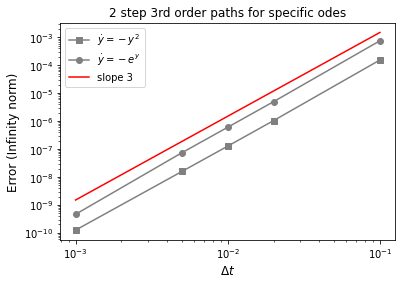

In [5]:
timesteps = np.array([0.001, 0.005, 0.01, 0.02, 0.1])
#schemes = ['Euler 1-step 1-order', 'Euler 2-step 2-order', 'Euler 3-step 3-order','Euler 2-step 3-order exp','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']
schemes = ['Euler 2-step 3-order', 'Euler 2-step 3-order exp']
odes = [square, exponential]

ax = plt.subplot(111)

for ode in odes:
    er = convergence_test(timesteps, schemes, ode)
    if ode.name == 'square':
        ax.loglog(timesteps, er[:, 0], '-s', color = 'gray', label = r'$\dot{y}= -y^2$')
    else:
        ax.loglog(timesteps, er[:, 1], '-o', color = 'gray',label = r'$\dot{y}= -e^y$')
    #ax.loglog(timesteps, er[:, 2], 'r',label = '3-3')
    
ax.loglog([10**(-3),10**(-1)], [1.5*10**(-9), 1.5*10**(-3)],'r', label = 'slope 3')

ax.legend()
plt.title('2 step 3rd order paths for specific odes')
plt.xlabel(r'$\Delta t$', fontsize = 12)
plt.ylabel('Error (Infinity norm)', fontsize = 12)
plt.savefig('2step3.pdf')